In [119]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import lightning as L
import neptune.new as neptune
from torchmetrics import Precision
import os
import pandas as pd
from lightning.pytorch.callbacks import TQDMProgressBar
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

In [2]:
def norm(data):
    return (data - data.min()) / (data.max() - data.min())

In [3]:
from sklearn.preprocessing import LabelEncoder

train_dir = './train'

path = f'{train_dir}/tdcsfog'
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
tdcsfog_df = pd.concat([pd.read_csv(f).assign(Id=f.split('/')[-1].split('.')[0]) for f in files])
tdcsfog_df.index=range(len(tdcsfog_df))

path = f'{train_dir}/defog'
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
defog_df = pd.concat([pd.read_csv(f).assign(Id=f.split('/')[-1].split('.')[0]) for f in files])
defog_df.index=range(len(defog_df))
# normalize 
defog_df['AccV']=defog_df['AccV']/9.8
defog_df['AccML']=defog_df['AccML']/9.8
defog_df['AccAP']=defog_df['AccAP']/9.8

defog_df['AccV']=norm(defog_df['AccV'])
defog_df['AccML']=norm(defog_df['AccML'])
defog_df['AccAP']=norm(defog_df['AccAP'])

tdcsfog_df['AccV']=norm(tdcsfog_df['AccV'])
tdcsfog_df['AccML']=norm(tdcsfog_df['AccML'])
tdcsfog_df['AccAP']=norm(tdcsfog_df['AccAP'])


df = pd.concat([tdcsfog_df,defog_df])

tdcsfog_metadata = pd.read_csv(f'./tdcsfog_metadata.csv')
defog_metadata = pd.read_csv(f'./defog_metadata.csv')
metadata= pd.concat([tdcsfog_metadata,defog_metadata])
df = df.merge(metadata, on='Id', how='inner')
encoder = LabelEncoder()
df['Id']=encoder.fit_transform(df['Id'])

In [4]:
def get_idx_of_lables(df):
    any_ones = df[['StartHesitation', 'Turn', 'Walking']].eq(1).any(axis=1)
    idx_with_ones = df[any_ones].index
    return idx_with_ones

def wind(df, window):
    lable_indexes = list(get_idx_of_lables(df))
    times = np.array(df['Time'])

    lable_indexes = np.array(lable_indexes)
    mask = np.where(lable_indexes[1:] - lable_indexes[:-1] != 1)[0]

    start_segments = lable_indexes[np.concatenate((np.array([0]), mask + 1))]
    end_segments = lable_indexes[np.concatenate((mask, np.array([len(lable_indexes) - 1])))]

    res = []

    for start, end in zip(start_segments, end_segments):
        res.extend(times[max(0, start - window // 2):start])
        res.extend(lable_indexes[start:end+1])
        res.extend(times[end:min(len(times)-1, end + window // 4)])

    return res

def window(df, window_size):
    win_has_label_idx = wind(df, window_size)
    return df.iloc[win_has_label_idx]

windowed_df = pd.concat([window(tdcsfog_df,256),window(defog_df,200)])
tdcsfog_metadata = pd.read_csv(f'./tdcsfog_metadata.csv')
defog_metadata = pd.read_csv(f'./defog_metadata.csv')
metadata= pd.concat([tdcsfog_metadata,defog_metadata])
windowed_df = windowed_df.merge(metadata, on='Id', how='inner')
encoder = LabelEncoder()
windowed_df['Id']=encoder.fit_transform(windowed_df['Id'])

In [5]:
def tensor_to_num(y):

    for i in range(3):
        if y[i]==1:
            return torch.tensor(i+1,dtype=torch.float).cuda()
    return torch.tensor(i+1,dtype=torch.float).cuda()

def num_to_tensor(y):
    for i in range(4):
        if y==i:
            res= torch.zeros(3).cuda()
            if i!=0:
                res[i-1]=1
            return res
def add_to_tensor(y):
    if torch.all(y == 0):
        return torch.cat((torch.tensor([1]).cuda(), y), dim=0).cuda()
    else:
        return torch.cat((torch.tensor([0]).cuda(), y), dim=0).cuda()

In [6]:
class DS(Dataset):
    def __init__(self, df, labels,seq_len=1):
        self.df=df
        self.labels = labels
        self.seq_len=seq_len
        # self.chunks = dataframe_chunks(df, seq_len)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"        
        record = self.df.iloc[idx]
        x = torch.Tensor(record[['AccV', 'AccML', 'AccAP']]).view(3, 1).to(self.device)
        # x = torch.transpose(x, 0, 1).to(self.device)
        y = x = torch.Tensor(record[self.labels]).view(3, 1).to(self.device).to(self.device)
        # y =torch.transpose(y, 0, 1).to(self.device)
        y=torch.any(y != 0, dim=1).float().to(self.device)
        return x, add_to_tensor(y)


# train test split

In [8]:
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Subset


X = windowed_df.drop(['AccV', 'AccML', 'AccAP'], axis=1)
y = windowed_df[['AccV', 'AccML', 'AccAP']]

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, val_idx = next(gss.split(X, y, windowed_df['Subject']))
train_df,val_df =windowed_df.iloc[train_idx],df.iloc[val_idx]

train_ds = DS(train_df,['StartHesitation','Turn','Walking'])
validation_ds = DS(val_df,['StartHesitation','Turn','Walking'])

len(train_df)/len(windowed_df),len(val_df)/len(windowed_df)

(0.7734778718331602, 0.22652212816683975)

# Model 

In [73]:
def train_model(model,tags,epochs,batch_size,lr):
    trainer = L.Trainer(
        callbacks=[TQDMProgressBar(refresh_rate=100)],
        accelerator='auto',
        max_epochs=epochs,
        devices=1,
    )
    run = neptune.init_run(
        project="harelmx/deep-hw2",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZDUzNTU3NC0xMzczLTQ4NGQtYTVhOS1jZGJmNzQ3MTA3ZjIifQ==",
    )  
    run["sys/tags"].add(tags)
    run["config/lr"]=lr
    run["config/epochs"]=trainer.max_epochs
    run["config/batch_size"]=batch_size
    model.run=run
    model.lr=lr
    trainer.fit(model,model.train_loader,model.val_loader)


In [70]:
class OneDimConvModel(L.LightningModule):
    def __init__(self, train_loader, val_loader, seq_len, num_classes=4, neptune_run=None) -> None:
        super().__init__()
        # self.save_hyperparameters()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.run = neptune_run
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv1d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64 * seq_len, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        return self.run_this_shit(batch, batch_idx,'train')

    def validation_step(self, batch, batch_idx):
        return self.run_this_shit(batch, batch_idx,'validation')
    
    def run_this_shit(self, batch, batch_idx,call_from):
        X, y = batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        if self.run:
            self.run[f'{call_from}/loss'].append(loss.item())
        
        return loss

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


# training

In [38]:
BATCH_SIZE = 128
device='cuda'
lr=1e-4
epochs=5
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=False)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)
model=OneDimConvModel(train_loader,val_loader,train_ds.seq_len)
train_model(model,['try'],epochs,BATCH_SIZE,lr)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-155


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 516   
8 | dropout | Dropout     | 0     
----------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 6220/6220 [18:38<00:00,  5.56it/s, v_num=22]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 6220/6220 [18:35<00:00,  5.58it/s, v_num=22]      
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 6220/6220 [18:46<00:00,  5.52it/s, v_num=22]      
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 6220/6220 [18:39<00:00,  5.56it/s, v_num=22]      
Validation: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 0/6220 [1:40:09<?, ?it/s]

Epoch 4: 100%|██████████| 6220/6220 [18:46<00:00,  5.52it/s, v_num=22]      
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 6220/6220 [24:11<00:00,  4.29it/s, v_num=22]      

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 6220/6220 [24:11<00:00,  4.29it/s, v_num=22]


In [39]:
BATCH_SIZE = 256
device='cuda'
lr=1e-4
epochs=5
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=False)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)
model=OneDimConvModel(train_loader,val_loader,train_ds.seq_len)
train_model(model,['try'],epochs,BATCH_SIZE,lr)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-156


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 516   
8 | dropout | Dropout     | 0     
----------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 3110/3110 [19:07<00:00,  2.71it/s, v_num=23]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 3110/3110 [18:29<00:00,  2.80it/s, v_num=23]    
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 3110/3110 [18:24<00:00,  2.82it/s, v_num=23]    
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 3110/3110 [18:35<00:00,  2.79it/s, v_num=23]    
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 3110/3110 [18:34<00:00,  2.79it/s, v_num=23]    
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 3110/3110 [23:58<00:00,  2.16it/s, v_num=23]    

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3110/3110 [23:58<00:00,  2.16it/s, v_num=23]


In [40]:
BATCH_SIZE = 128
device='cuda'
lr=1e-5
epochs=5
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=False)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)
model=OneDimConvModel(train_loader,val_loader,train_ds.seq_len)
train_model(model,['try'],epochs,BATCH_SIZE,lr)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-157


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 516   
8 | dropout | Dropout     | 0     
----------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 6220/6220 [20:04<00:00,  5.16it/s, v_num=24]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 6220/6220 [20:26<00:00,  5.07it/s, v_num=24]      
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 6220/6220 [20:21<00:00,  5.09it/s, v_num=24]      
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 6220/6220 [18:35<00:00,  5.58it/s, v_num=24]      
Validation: 0it [00:00, ?it/s]
Epoch 4:  26%|██▌       | 1600/6220 [04:46<13:48,  5.58it/s, v_num=24]      

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [41]:
BATCH_SIZE = 128
device='cuda'
lr=1e-4
epochs=5
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)
model=OneDimConvModel(train_loader,val_loader,train_ds.seq_len)
train_model(model,['try'],epochs,BATCH_SIZE,lr)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-158


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 516   
8 | dropout | Dropout     | 0     
----------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 6220/6220 [18:38<00:00,  5.56it/s, v_num=25]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 6220/6220 [18:41<00:00,  5.55it/s, v_num=25]      
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 6220/6220 [18:42<00:00,  5.54it/s, v_num=25]      
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 6220/6220 [18:49<00:00,  5.50it/s, v_num=25]      
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 6220/6220 [18:37<00:00,  5.57it/s, v_num=25]      
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 6220/6220 [24:00<00:00,  4.32it/s, v_num=25]      

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 6220/6220 [24:00<00:00,  4.32it/s, v_num=25]


In [42]:
BATCH_SIZE = 256
device='cuda'
lr=1e-4
epochs=5
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)
model=OneDimConvModel(train_loader,val_loader,train_ds.seq_len)
train_model(model,['try'],epochs,BATCH_SIZE,lr)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-159


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 516   
8 | dropout | Dropout     | 0     
----------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 3110/3110 [18:15<00:00,  2.84it/s, v_num=26]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 3110/3110 [18:17<00:00,  2.83it/s, v_num=26]    
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 3110/3110 [18:18<00:00,  2.83it/s, v_num=26]    
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 3110/3110 [18:13<00:00,  2.84it/s, v_num=26]    
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 3110/3110 [18:14<00:00,  2.84it/s, v_num=26]    
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 3110/3110 [23:29<00:00,  2.21it/s, v_num=26]    

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3110/3110 [23:29<00:00,  2.21it/s, v_num=26]


In [ ]:
BATCH_SIZE = 128
device='cuda'
lr=1e-3
epochs=5
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)
model=OneDimConvModel(train_loader,val_loader,train_ds.seq_len)
train_model(model,['try'],epochs,BATCH_SIZE,lr)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-160


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 516   
8 | dropout | Dropout     | 0     
----------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 6220/6220 [18:31<00:00,  5.60it/s, v_num=27]
Validation: 0it [00:00, ?it/s]
Epoch 1:   5%|▍         | 300/6220 [00:55<18:17,  5.39it/s, v_num=27]       

# performance analysis

In [71]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE,shuffle=False)

cnn= OneDimConvModel.load_from_checkpoint('./cnn.ckpt',train_loader=train_loader,val_loader=val_loader,seq_len=train_ds.seq_len).cuda()

In [95]:
def precision(model,loader):
    precision = Precision(task="multiclass", num_classes=4).cuda()
    precision_lst=[]
    for batch_idx, (x, y) in enumerate(loader):
        y_hat = model(x)
        pred = torch.argmax(y_hat, dim=1)
        actual = torch.argmax(y, dim=1)
        precision_lst.append(precision(pred,actual))
    return sum(precision_lst)/len(precision_lst) 

In [97]:
f'precision is {precision(cnn,val_loader)}'

'precision is 0.22928796708583832'

In [124]:
from collections import defaultdict
def plot_count(model,loader):
    counter =  defaultdict(int)
    for batch_idx, (x, y) in enumerate(loader):
        y_hat = model(x)
        pred = torch.argmax(y_hat, dim=1)
        actual = torch.argmax(y, dim=1)
        for i,c in enumerate(actual):
            if c==pred[i]:
                counter[f'{c.item()} currect']+=1
            else:
                counter[f'{c.item()} incurrect']+=1

    data = {"Category": list(counter.keys()), "Values": list(counter.values())}
    df = pd.DataFrame(data)
    df = df.sort_values(by="Category")
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Category", y="Values", data=df)
    plt.show()

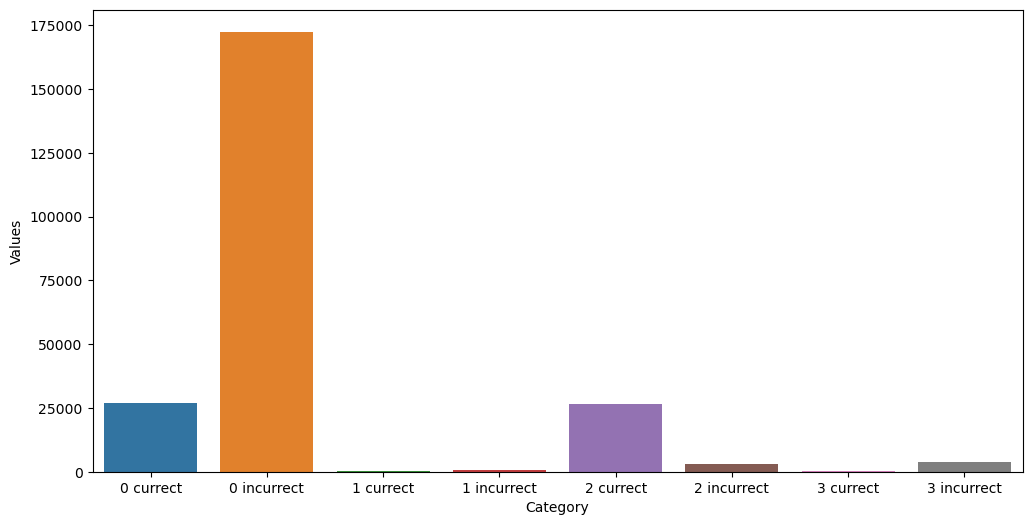

In [125]:
plot_count(cnn,val_loader)

# Fine tuning

In [65]:
class fogDataset(Dataset):
    def __init__(self, df, ds_type=None):
        self.ds_type = ds_type
        self.df = df      
        self.features = ['AccV', 'AccML', 'AccAP']
        if ds_type == "self":
            self.labels = ['AccVAboveAverage', 'AccMLAboveAverage', 'AccAPAboveAverage']
        else:
            self.labels = ['StartHesitation', 'Turn' , 'Walking']
    
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        y = torch.Tensor(record[self.labels])
        x = torch.Tensor(record[self.features])        
     
        return x.view(3,1),y
    
    def get_head(self):
        return self.df.head()
        

In [67]:
def self_supervised_target(df):
    AccVthreshold = df['AccV'].mean() 
    AccMLthreshold = df['AccML'].mean() 
    AccAPthreshold = df['AccAP'].mean() 
    df['AccVAboveAverage'] = df['AccV'].apply(lambda x: 1 if x > AccVthreshold else 0)
    df['AccMLAboveAverage'] = df['AccML'].apply(lambda x: 1 if x > AccMLthreshold else 0)
    df['AccAPAboveAverage'] = df['AccAP'].apply(lambda x: 1 if x > AccAPthreshold else 0)
    return df


ss_train_df = self_supervised_target(train_df).drop(['StartHesitation', 'Turn', 'Walking', 'Id','Subject','Valid','Task'], axis=1)
ss_val_df = self_supervised_target(val_df).drop(['StartHesitation', 'Turn', 'Walking', 'Id','Subject','Valid','Task'], axis=1)

ss_train_ds = fogDataset(ss_train_df, "self")
ss_validation_ds = fogDataset(ss_val_df, "self")

/tmp/ipykernel_9395/2034464694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AccVAboveAverage'] = df['AccV'].apply(lambda x: 1 if x > AccVthreshold else 0)
/tmp/ipykernel_9395/2034464694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AccMLAboveAverage'] = df['AccML'].apply(lambda x: 1 if x > AccMLthreshold else 0)
/tmp/ipykernel_9395/2034464694.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [75]:
import copy
cnn_mean = copy.deepcopy(cnn) 
cnn_mean.fc2=nn.Linear(128, 3)
cnn_mean.train_ds=ss_train_ds 
BATCH_SIZE =256
cnn_mean.train_loader= torch.utils.data.DataLoader(ss_train_ds, batch_size=BATCH_SIZE,shuffle=True)
cnn_mean.val_loader= torch.utils.data.DataLoader(ss_validation_ds, batch_size=BATCH_SIZE,shuffle=False)
train_model(cnn_mean,['fine-tuning'],3,BATCH_SIZE,1e-3)

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/moshayof/.conda/envs/harel/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


https://app.neptune.ai/harelmx/deep-hw2/e/DEEP2-170


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv1d      | 160   
1 | bn1     | BatchNorm1d | 32    
2 | conv2   | Conv1d      | 1.6 K 
3 | bn2     | BatchNorm1d | 64    
4 | conv3   | Conv1d      | 6.2 K 
5 | bn3     | BatchNorm1d | 128   
6 | fc1     | Linear      | 8.3 K 
7 | fc2     | Linear      | 387   
8 | dropout | Dropout     | 0     
----------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.067     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 3110/3110 [13:10<00:00,  3.94it/s, v_num=45]
Validation: 0it [00:00, ?it/s]
Epoch 1:  45%|████▌     | 1400/3110 [05:54<07:13,  3.94it/s, v_num=45]    

/home/moshayof/.conda/envs/harel/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [98]:
cnn_mean.fc2=cnn.fc2
f'precision is {precision(cnn_mean,val_loader)}'

'precision is 0.860185444355011'

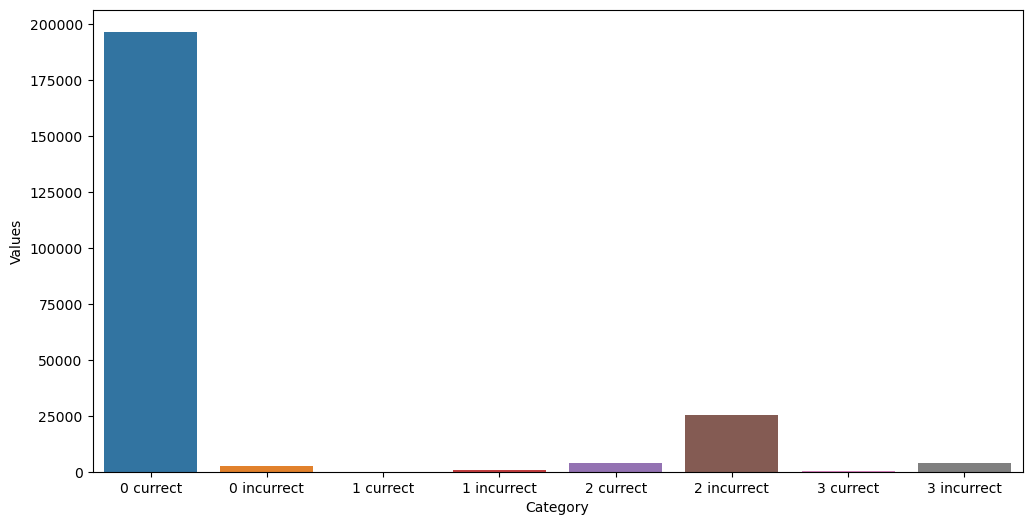

In [127]:
plot_count(cnn_mean,val_loader)